# Binning by IDACI and FSM

Here we attempt to evaluate activity among certain subgroups of the population. 

## Load the data 

Load and cleaning the data. Also setting the bins for the active and inactive groups. 


In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import stats_helper_files as stat


# Inputs
external_csv = r"/home/andris/GitHub/data/school_ext_data.csv"
internal_csv = r"/home/andris/GitHub/data/school_clk_data.csv"

In [184]:
# ------------------------------------------------------
# JOIN EXTERNAL DATA WITH CLICKSTREAM DATA
# ------------------------------------------------------

# Read external data (indices and exam results)
df_ext = pd.read_csv(external_csv)
print('Total number of schools in external spreadsheet:',len(df_ext))

# Read internal data (clickstream data)
df_int = pd.read_csv(internal_csv)
print('Total number of schools in internal spreadsheet:',len(df_int))

# Combine the 2 dataframes
df_ext['URN'] = df_ext['URN'].astype('str') 
df = df_ext.set_index('URN').join(df_int.set_index('school_id'))
print('Number of schools after joining:',len(df))

#  All clickstream data that is not defined is set to 0
df = df.fillna(0)

# Select the schools that have provide all science courses in all years
df = df[(df.filter(regex='Entries') > 0).all(axis=1)]
print('Number of schools that had all science courses:',len(df))


Total number of schools in external spreadsheet: 2776
Total number of schools in internal spreadsheet: 1238
Number of schools after joining: 2776
Number of schools that had all science courses: 899


In [185]:
# ------------------------------------------------------
# ADDING NEW FEATURES AND INDICES
# ------------------------------------------------------

# Computing improvement in exam scores

qu = ['Biology','Mathematics','Chemistry','Physics']

# Defining it relative to the mean

for item in qu:
    df['exam_improv_2013-2014_' + item] = (df['exam_score|2014_'+item] - df['exam_score|2013_'+item]) - (df['exam_score|2014_'+item] - df['exam_score|2013_'+item]).mean()

for item in qu:
    df['exam_improv_2013-2016_' + item] = (df['exam_score|2016_'+item] - df['exam_score|2013_'+item]) - (df['exam_score|2016_'+item] - df['exam_score|2013_'+item]).mean()

# Student activity
df['std_q_cor'] =  (df.filter(regex='_cor_std').sum(axis=1)/df['Entries|2016_Physics']).fillna(0)
df['std_ratio'] =  (df['user_id_std']/df['Entries|2016_Physics']).fillna(0) 

# Trying a combination
df['combo'] = (df['std_q_cor']/df['std_q_cor'].mean()) + (df['std_ratio']/df['std_ratio'].mean())

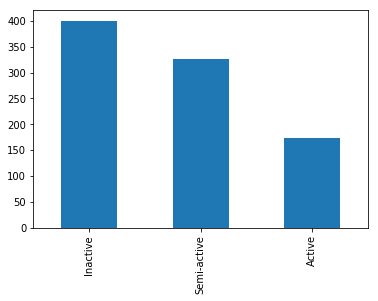

In [186]:
# Let's bin each school according to their activity on IP


bins = [-0.1, 0, 2,10000]
group_names = ['Inactive','Semi-active','Active']

df['categories'] = stat.bin_groups(df,'combo',bins,group_names)

# Plot a histogram
df['categories'].value_counts().plot(kind='bar')
plt.savefig('distribution.png', format='png', dpi=300)


## Looking at FSM

Here we bin the schools according to 3 FSM categroies and look at the distribution of scores for each section. 

In [188]:
# Let's first remove the schools that have a FSM of 0% because, it is unreliable

df['PercentageFSM'] = [np.nan if item == 0 else item for item in df['PercentageFSM']]

print('Number of remaining schools:',len(df))

# Bin into identical categories
N_categories = 3;
labels = ['Low','Medium','High']

df['FSM_group'], bins = pd.qcut(df['PercentageFSM'], N_categories, labels = labels, retbins = True)

print(bins)

Number of remaining schools: 899
[  0.3   3.9   7.4  44.1]


In [203]:
df['PercentageFSM'].count()

554

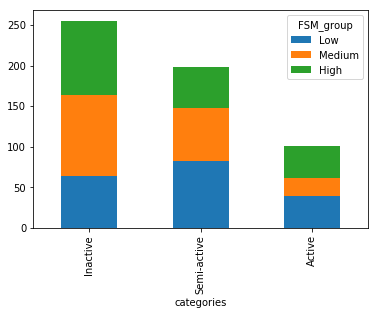

In [190]:
# Let's plot the distribution

df4=df.groupby(['categories','FSM_group']).size()
df4=df4.unstack()
df4.plot(kind='bar', stacked=True)

Exam improvement between Low, Medium and High FSM groups of those schools that are inactive


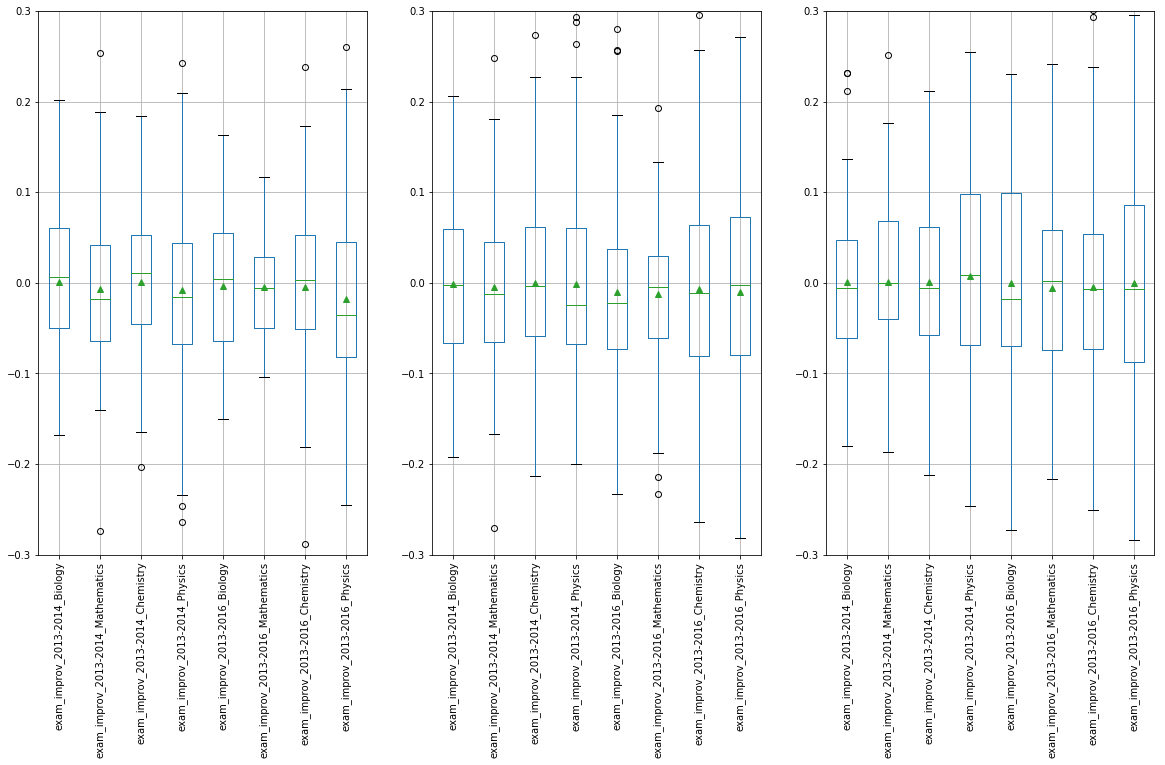

In [191]:
df_plot = df[df['categories'] == 'Inactive']

_, axs = plt.subplots(1,3,figsize=(20,10),sharey=True)

plt.subplot(1,3,1)
df_plot[df_plot['FSM_group']=='Low'].filter(regex='exam_improv').boxplot(rot=90, showmeans=True).set_ylim(-0.3,0.3)
plt.subplot(1,3,2)
df_plot[df_plot['FSM_group']=='Medium'].filter(regex='exam_improv').boxplot(rot=90, showmeans=True).set_ylim(-0.3,0.3)
plt.subplot(1,3,3)
df_plot[df_plot['FSM_group']=='High'].filter(regex='exam_improv').boxplot(rot=90, showmeans=True).set_ylim(-0.3,0.3)

print('Exam improvement between Low, Medium and High FSM groups of those schools that are inactive')



Exam improvement between Low, Medium and High FSM groups of those that are active


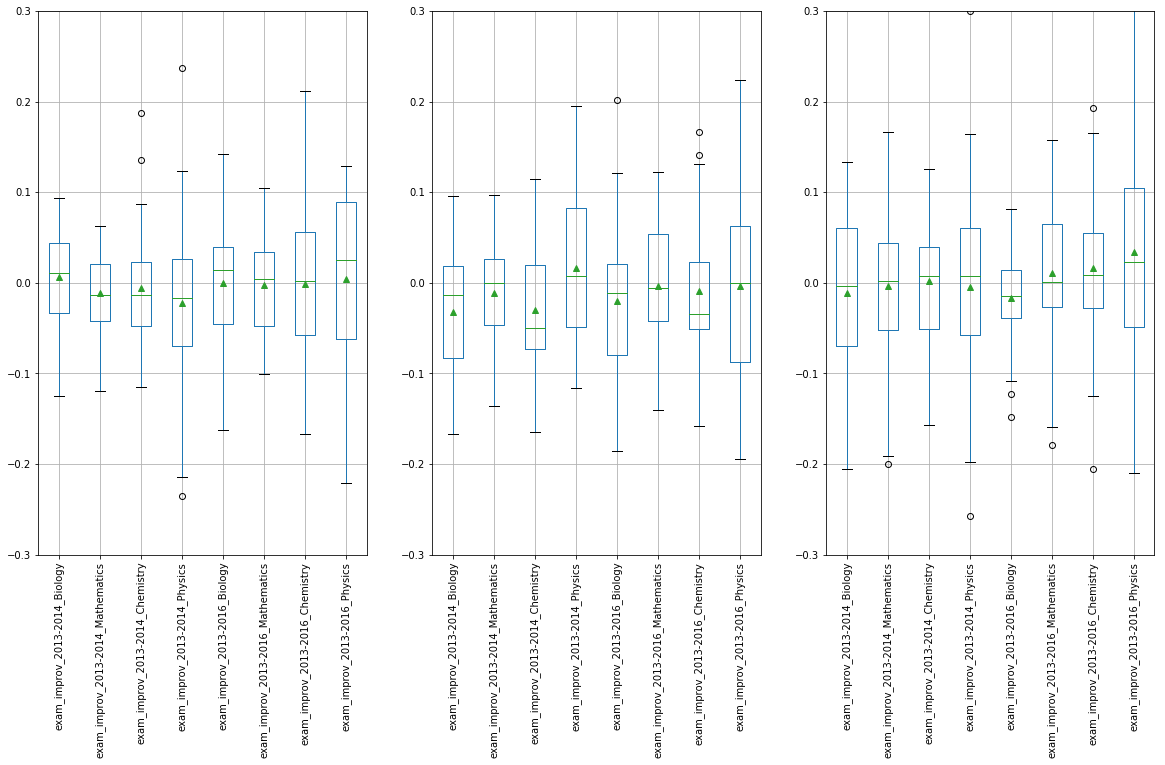

In [192]:
df_plot = df[df['categories'] == 'Active']

_, axs = plt.subplots(1,3,figsize=(20,10),sharey=True)

plt.subplot(1,3,1)
df_plot[df_plot['FSM_group']=='Low'].filter(regex='exam_improv').boxplot(rot=90, showmeans=True).set_ylim(-0.3,0.3)
plt.subplot(1,3,2)
df_plot[df_plot['FSM_group']=='Medium'].filter(regex='exam_improv').boxplot(rot=90, showmeans=True).set_ylim(-0.3,0.3)
plt.subplot(1,3,3)
df_plot[df_plot['FSM_group']=='High'].filter(regex='exam_improv').boxplot(rot=90, showmeans=True).set_ylim(-0.3,0.3)

print('Exam improvement between Low, Medium and High FSM groups of those that are active')

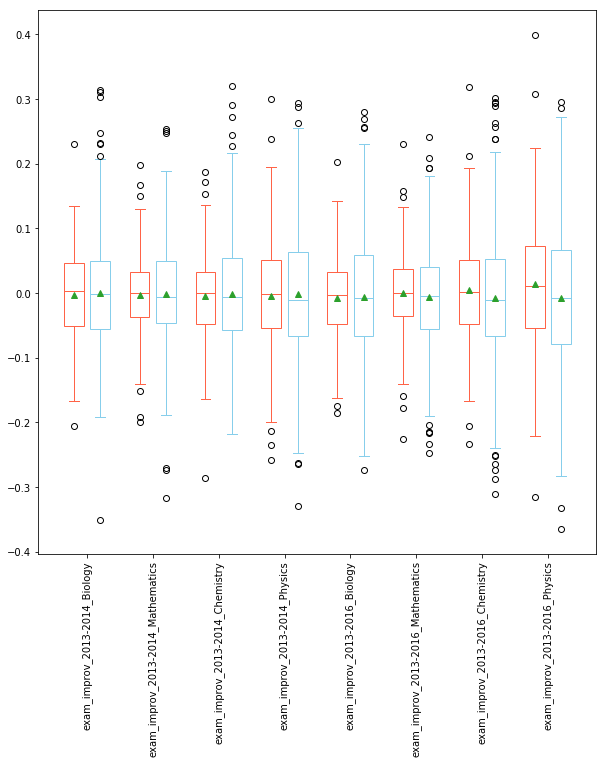

In [193]:
A = df[df['categories'] == 'Active'].filter(regex='exam_improv').values
B = df[df['categories'] == 'Inactive'].filter(regex='exam_improv').values

def draw_plot(data, offset,edge_color, fill_color):
    pos = np.arange(data.shape[1])+offset 
    bp = ax.boxplot(data, positions= pos, widths=0.3, patch_artist=True, manage_xticks=False,showmeans=True)
    for element in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)
    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)

fig, ax = plt.subplots(figsize=(10,10))

plt.xticks(rotation=90)
labels = np.array(df.filter(regex='exam_improv').columns)
labels = np.insert(labels,0,0)
ax.set_xticklabels(labels)
#

draw_plot(A, -0.2, "tomato", "white")
draw_plot(B, +0.2,"skyblue", "white")


## Looking at the IDACI

Now lets bin everything by the IDACI index and see if exam performance can be linked to IP activity.

1.0    244
2.0    154
3.0     84
4.0     57
5.0     19
Name: IDACI, dtype: int64


558

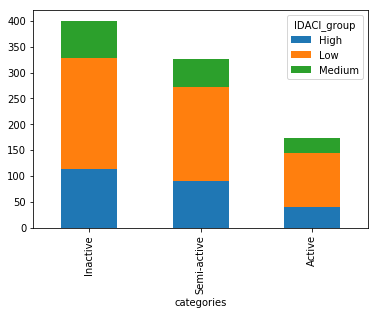

In [202]:
df['IDACI'] = [np.nan if item == 0 else item for item in df['IDACI']]

bin_val = df['IDACI'].value_counts()
print(bin_val)

# Anything with IDACI 1 set as High, IDACI 2 as Medium and IDACI 3,4,5 as Low
df['IDACI_group'] = df['IDACI']*0

store = []
for item in df['IDACI']:

    if item == 1.0:
        store.append('High')
    elif item == 2.0:
        store.append('Medium')
    else:
        store.append('Low')
        
df['IDACI_group'] = store

df4=df.groupby(['categories','IDACI_group']).size()
df4=df4.unstack()
df4.plot(kind='bar', stacked=True)

df['IDACI'].count()

Exam improvement between Low, Medium and IDACI FSM groups of those schools that are inactive


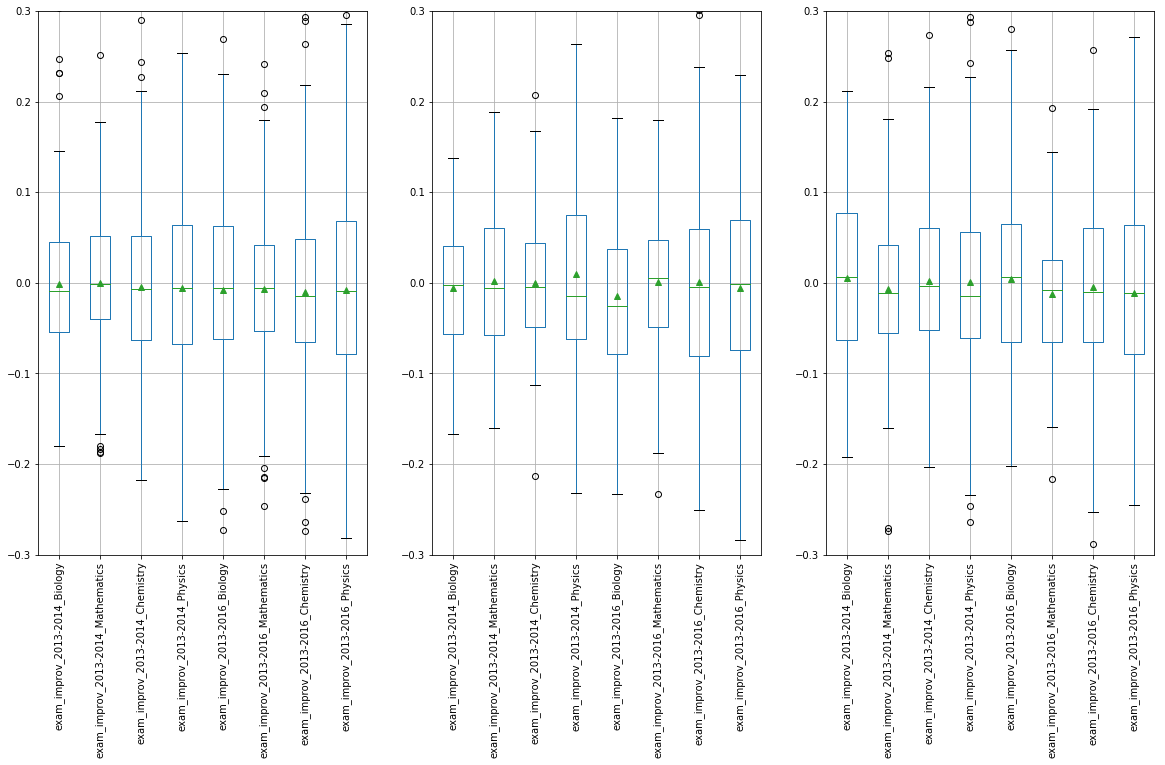

In [196]:
df_plot = df[df['categories'] == 'Inactive']

_, axs = plt.subplots(1,3,figsize=(20,10),sharey=True)

plt.subplot(1,3,1)
df_plot[df_plot['IDACI_group']=='Low'].filter(regex='exam_improv').boxplot(rot=90, showmeans=True).set_ylim(-0.3,0.3)
plt.subplot(1,3,2)
df_plot[df_plot['IDACI_group']=='Medium'].filter(regex='exam_improv').boxplot(rot=90, showmeans=True).set_ylim(-0.3,0.3)
plt.subplot(1,3,3)
df_plot[df_plot['IDACI_group']=='High'].filter(regex='exam_improv').boxplot(rot=90, showmeans=True).set_ylim(-0.3,0.3)

print('Exam improvement between Low, Medium and IDACI FSM groups of those schools that are inactive')



Exam improvement between Low, Medium and IDACI FSM groups of those schools that are inactive


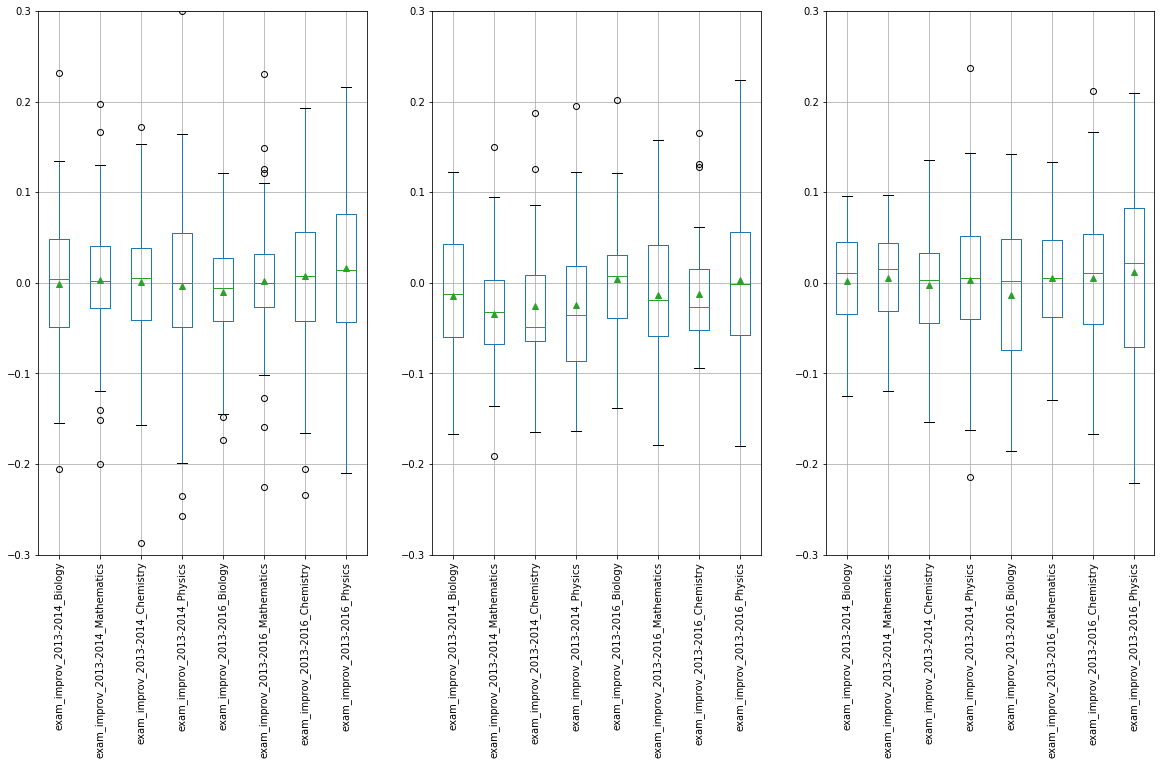

In [197]:
df_plot = df[df['categories'] == 'Active']

_, axs = plt.subplots(1,3,figsize=(20,10),sharey=True)

plt.subplot(1,3,1)
df_plot[df_plot['IDACI_group']=='Low'].filter(regex='exam_improv').boxplot(rot=90, showmeans=True).set_ylim(-0.3,0.3)
plt.subplot(1,3,2)
df_plot[df_plot['IDACI_group']=='Medium'].filter(regex='exam_improv').boxplot(rot=90, showmeans=True).set_ylim(-0.3,0.3)
plt.subplot(1,3,3)
df_plot[df_plot['IDACI_group']=='High'].filter(regex='exam_improv').boxplot(rot=90, showmeans=True).set_ylim(-0.3,0.3)

print('Exam improvement between Low, Medium and IDACI FSM groups of those schools that are inactive')



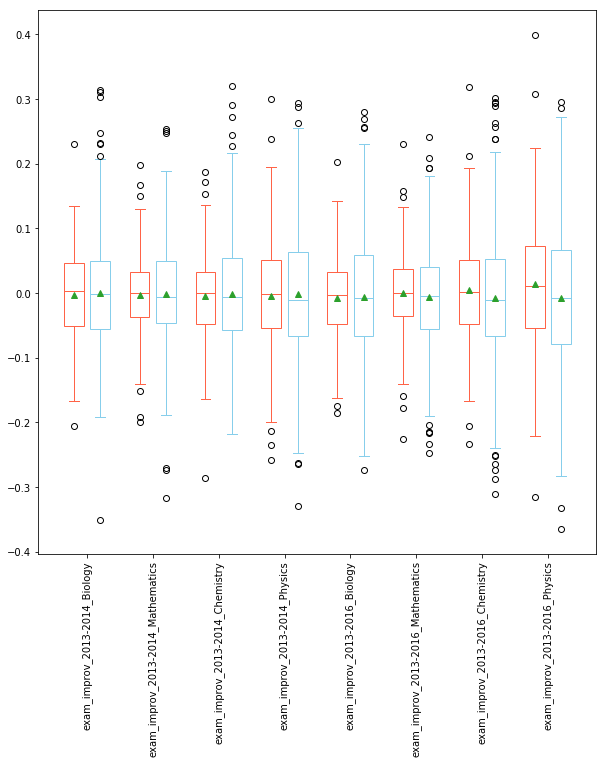

In [198]:
A = df[df['categories'] == 'Active'].filter(regex='exam_improv').values
B = df[df['categories'] == 'Inactive'].filter(regex='exam_improv').values

def draw_plot(data, offset,edge_color, fill_color):
    pos = np.arange(data.shape[1])+offset 
    bp = ax.boxplot(data, positions= pos, widths=0.3, patch_artist=True, manage_xticks=False,showmeans=True)
    for element in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)
    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)

fig, ax = plt.subplots(figsize=(10,10))

plt.xticks(rotation=90)
labels = np.array(df.filter(regex='exam_improv').columns)
labels = np.insert(labels,0,0)
ax.set_xticklabels(labels)
#

draw_plot(A, -0.2, "tomato", "white")
draw_plot(B, +0.2,"skyblue", "white")


In [199]:
df

,Entries|2013_Biology,Entries|2013_Chemistry,Entries|2013_Mathematics,Entries|2013_Physics,Entries|2014_Biology,Entries|2014_Chemistry,Entries|2014_Mathematics,Entries|2014_Physics,Entries|2015_Biology,Entries|2015_Chemistry,...,exam_improv_2013-2016_Biology,exam_improv_2013-2016_Mathematics,exam_improv_2013-2016_Chemistry,exam_improv_2013-2016_Physics,std_q_cor,std_ratio,combo,categories,FSM_group,IDACI_group
URN,,,,,,,,,,,,,,,,,,,,,
100001,19.0,25.0,53.0,17.0,16.0,20.0,41.0,17.0,15.0,14.0,...,0.030066,-0.024760,0.006852,-0.052024,16.300000,0.200000,1.188848,Semi-active,NaN,Low
100003,24.0,35.0,77.0,41.0,39.0,37.0,88.0,34.0,26.0,45.0,...,-0.019782,0.005115,0.000450,0.117477,72.774194,0.548387,4.055892,Active,NaN,Low
100054,32.0,21.0,75.0,29.0,34.0,35.0,69.0,21.0,42.0,28.0,...,-0.034802,0.001270,0.013254,-0.028243,17.307692,0.435897,2.074562,Active,High,Low
100065,33.0,35.0,70.0,28.0,30.0,34.0,67.0,31.0,25.0,29.0,...,0.065091,-0.019071,0.047805,0.124447,72.114286,1.057143,5.885767,Active,NaN,Low
100076,10.0,14.0,27.0,11.0,18.0,21.0,32.0,12.0,22.0,20.0,...,-0.109206,-0.004825,-0.014637,-0.052069,1.714286,0.071429,0.308142,Semi-active,NaN,Low
100190,14.0,21.0,43.0,13.0,16.0,23.0,34.0,16.0,16.0,27.0,...,0.064543,0.022966,-0.054829,0.070244,0.000000,0.000000,0.000000,Inactive,High,Low
100202,14.0,10.0,21.0,8.0,17.0,7.0,27.0,11.0,10.0,11.0,...,0.093542,0.041960,0.118241,0.127224,0.000000,0.000000,0.000000,Inactive,NaN,Low
100279,14.0,9.0,13.0,6.0,19.0,15.0,26.0,9.0,23.0,13.0,...,0.006744,0.042420,0.088954,0.307780,20.812500,0.812500,3.542331,Active,High,Low
100366,34.0,39.0,62.0,19.0,27.0,34.0,64.0,18.0,30.0,34.0,...,0.075953,0.017398,0.029673,0.080587,195.350000,1.700000,11.715613,Active,NaN,Low
